In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prompt_toolkit.key_binding.bindings.named_commands import self_insert
#데이터 증강에 필요한 라이브러리
from scipy.ndimage import median_filter, rotate, shift
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

### 패딩 조져서 60,60 ->: 3600으로 만들고 kernel size = 8 stride = 4로 커널이 지나가면서 통예수치 추출 이하 생략.,

In [2]:
df = pd.read_pickle("/Users/unsi/Downloads/LSWMD.pkl") 
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]


In [3]:
df['waferMap'][0].shape

(45, 48)

In [4]:
# failureType 열의 데이터 유형과 샘플 값 확인
print(df['failureType'].head(50))  # 상위 50개의 데이터를 확인


0         [[none]]
1         [[none]]
2         [[none]]
3         [[none]]
4         [[none]]
5         [[none]]
6         [[none]]
7         [[none]]
8         [[none]]
9         [[none]]
10        [[none]]
11        [[none]]
12        [[none]]
13        [[none]]
14        [[none]]
15        [[none]]
16        [[none]]
17        [[none]]
18        [[none]]
19         [[Loc]]
20        [[none]]
21        [[none]]
22        [[none]]
23        [[none]]
24        [[none]]
25        [[none]]
26        [[none]]
27        [[none]]
28        [[none]]
29        [[none]]
30        [[none]]
31        [[none]]
32        [[none]]
33        [[none]]
34        [[none]]
35              []
36    [[Edge-Loc]]
37    [[Edge-Loc]]
38    [[Edge-Loc]]
39    [[Edge-Loc]]
40         [[Loc]]
41    [[Edge-Loc]]
42    [[Edge-Loc]]
43    [[Edge-Loc]]
44      [[Center]]
45              []
46        [[none]]
47         [[Loc]]
48    [[Edge-Loc]]
49      [[Center]]
Name: failureType, dtype: object


In [5]:
passed = df[df['failureType'].apply(lambda x: x.shape == (0, 0) or x[0][0] == 'none')]
passed['failureType'] = 8
eda_pass = passed
passed = passed.sample(n=100000, random_state=42)
faild = df[df['failureType'].apply(lambda x: len(x) > 0 and len(x[0]) > 0 and x[0][0] != 'none')]
faild
class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3,
    'Scratch': 4,
    'Random': 5,
    'Near-full': 6,
    'Donut': 7,
    'pass': 8
}

#failureType 인코딩 
faild['failureType'] = faild['failureType'].apply(lambda x: class2idx.get(x[0][0], -1))

# 결과 확인
faild
df = pd.concat([faild, passed])
df

/var/folders/9d/lcchyqrx6jq_hz6pm4d1j7z80000gn/T/ipykernel_83868/1353984034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passed['failureType'] = 8
/var/folders/9d/lcchyqrx6jq_hz6pm4d1j7z80000gn/T/ipykernel_83868/1353984034.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  faild['failureType'] = faild['failureType'].apply(lambda x: class2idx.get(x[0][0], -1))


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],0
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],1
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],1
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],1
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],1
...,...,...,...,...,...,...
334843,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20174,4.0,[],8
609203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot38319,13.0,[],8
244074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",648.0,lot15275,11.0,[],8
379250,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot22590,20.0,[],8


In [6]:
# failureType의 고유 값과 개수 세기
failure_counts = df['failureType'].value_counts()

print(failure_counts)

failureType
8    100000
3      9680
1      5189
2      4294
0      3593
4      1193
5       866
7       555
6       149
Name: count, dtype: int64


In [7]:
features = df['waferMap']
targets = df['failureType'].values
df = pd.concat([faild, passed])

In [8]:
features.shape

(125519,)

In [9]:
def apply_median_filter(wafer_map, size=3):
    return median_filter(wafer_map, size=size)
features = features.apply(lambda x: apply_median_filter(x, size=3))

In [10]:
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],0
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],1
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],1
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],1
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],1
...,...,...,...,...,...,...
334843,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20174,4.0,[],8
609203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot38319,13.0,[],8
244074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",648.0,lot15275,11.0,[],8
379250,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot22590,20.0,[],8


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 결함 유형 8을 새로운 라벨 7로 변환 (필요할 경우)


# 데이터 분할 (train, test split)
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=123, test_size=0.2)

print(f"훈련 데이터 수: {X_train.shape[0]}, 테스트 데이터 수: {X_test.shape[0]}")

훈련 데이터 수: 100415, 테스트 데이터 수: 25104


In [12]:
X_test.shape, y_test.shape

((25104,), (25104,))

In [13]:
X_test.shape, y_test.shape

((25104,), (25104,))

In [14]:
X_train_no_aug = X_train
y_train_no_aug = y_train

In [15]:
X_train_no_aug = X_train_no_aug.values

In [16]:
import numpy as np

# 데이터 증강 함수 (Train 데이터만 증강)
def augment_data(wafer_maps, targets):
    augmented_maps = []
    augmented_targets = []
    
    # 원본 웨이퍼 맵의 크기 확인 (첫 번째 맵을 기준으로)
    original_shape = wafer_maps[0].shape

    for wafer_map, target in zip(wafer_maps, targets):
        # 원본 데이터 추가 (리사이즈 없이 그대로)
        augmented_maps.append(pad_or_crop(wafer_map, original_shape))  # 원본 데이터도 일관된 크기로 추가
        augmented_targets.append(target)

        # 결함 있는 웨이퍼만 증강 (라벨 8 제외)
        if target != 8:
            # 90도 회전
            rotated_90 = np.rot90(wafer_map, k=-1)
            rotated_180 = np.rot90(wafer_map, k=2)
            rotated_270 = np.rot90(wafer_map, k=1)

            # 상하 및 좌우 뒤집기
            flipped_vertical = np.flip(wafer_map, axis=0)
            flipped_horizontal = np.flip(wafer_map, axis=1)

            # 회전 및 뒤집기 후 동일한 크기 유지 확인 및 강제 조정
            augmented_maps.append(pad_or_crop(rotated_90, original_shape))
            augmented_targets.append(target)

            augmented_maps.append(pad_or_crop(rotated_180, original_shape))
            augmented_targets.append(target)

            augmented_maps.append(pad_or_crop(rotated_270, original_shape))
            augmented_targets.append(target)

            augmented_maps.append(pad_or_crop(flipped_vertical, original_shape))
            augmented_targets.append(target)

            augmented_maps.append(pad_or_crop(flipped_horizontal, original_shape))
            augmented_targets.append(target)

    # 웨이퍼 맵의 모양이 모두 같은지 확인 및 배열화
    augmented_maps = np.array([np.array(wafer, dtype=np.float32) for wafer in augmented_maps])
    
    return augmented_maps, np.array(augmented_targets)

def pad_or_crop(image, target_shape):
    """
    이미지의 크기가 target_shape와 동일하지 않은 경우, 잘라내거나 패딩을 추가하여 동일한 크기로 만듭니다.
    """
    current_shape = image.shape
    padded_image = np.zeros(target_shape, dtype=image.dtype)

    # 이미지의 크기가 목표 크기보다 작다면, 중앙에 위치하도록 패딩
    padded_image[:min(current_shape[0], target_shape[0]), :min(current_shape[1], target_shape[1])] = \
        image[:min(current_shape[0], target_shape[0]), :min(current_shape[1], target_shape[1])]

    return padded_image

# 증강된 훈련 데이터
X_train_aug, y_train_aug = augment_data(X_train_no_aug, y_train_no_aug)

print(f"증강된 훈련 데이터의 형태: {X_train_aug.shape}")


증강된 훈련 데이터의 형태: (202490, 52, 59)


In [17]:
import numpy as np

def pad_images_to_same_size(images, target_shape):
    """
    모든 이미지를 동일한 크기(target_shape)로 패딩합니다.
    이미지가 target_shape보다 큰 경우 잘라냅니다.
    """
    padded_images = []
    for image in images:
        # 현재 이미지의 크기 가져오기
        current_shape = image.shape
        
        # 패딩된 이미지를 0으로 초기화 (target_shape 크기로)
        padded_image = np.zeros(target_shape, dtype=image.dtype)
        
        # 이미지의 크기가 목표 크기보다 작다면, 중앙에 위치하도록 복사
        padded_image[:min(current_shape[0], target_shape[0]), :min(current_shape[1], target_shape[1])] = \
            image[:min(current_shape[0], target_shape[0]), :min(current_shape[1], target_shape[1])]

        padded_images.append(padded_image)

    return np.array(padded_images)

# 모든 이미지를 동일한 크기로 패딩
target_shape = (60, 60)  # 예시로 (52, 59)로 설정
X_train_no_aug = pad_images_to_same_size(X_train_no_aug, target_shape)
X_train_aug = pad_images_to_same_size(X_train_aug, target_shape)
X_test = pad_images_to_same_size(X_test, target_shape)
# 각 이미지를 평탄화
X_train_no_aug = np.array([i.reshape(-1) for i in X_train_no_aug])
X_train_aug = np.array([i.reshape(-1) for i in X_train_aug])
X_test = np.array([i.reshape(-1) for i in X_test])
print(X_train_no_aug.shape)


(100415, 3600)


In [18]:
X_train_aug.shape

(202490, 3600)

In [19]:
import numpy as np

# 각 웨이퍼 맵에 대해 로그 변환을 개별적으로 적용
def apply_log1p_to_array(arr):
    return np.array([np.log1p(wafer) for wafer in arr])

# 로그 변환을 적용하여 0으로 인한 문제를 피하기 위해 np.log1p 사용 (log(1 + x))
X_train_no_aug = apply_log1p_to_array(X_train_no_aug)
X_test = apply_log1p_to_array(X_test)
X_train_aug = apply_log1p_to_array(X_train_aug)

# 결과 출력
print(X_train_aug[0])
print(X_train_no_aug[0])


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [20]:
print(X_train_aug.shape)

(202490, 3600)


In [21]:
y_train_aug.shape

(202490,)

In [22]:
import pandas as pd

# 결함 유형별 데이터 개수 세기
augmented_target_series = pd.Series(y_train_aug)
failure_counts_augmented = augmented_target_series.value_counts()

print("증강된 훈련 데이터의 결함 유형별 개수:")
print(failure_counts_augmented)

증강된 훈련 데이터의 결함 유형별 개수:
8    80000
3    46464
1    24906
2    20610
0    17244
4     5730
5     4158
7     2664
6      714
Name: count, dtype: int64


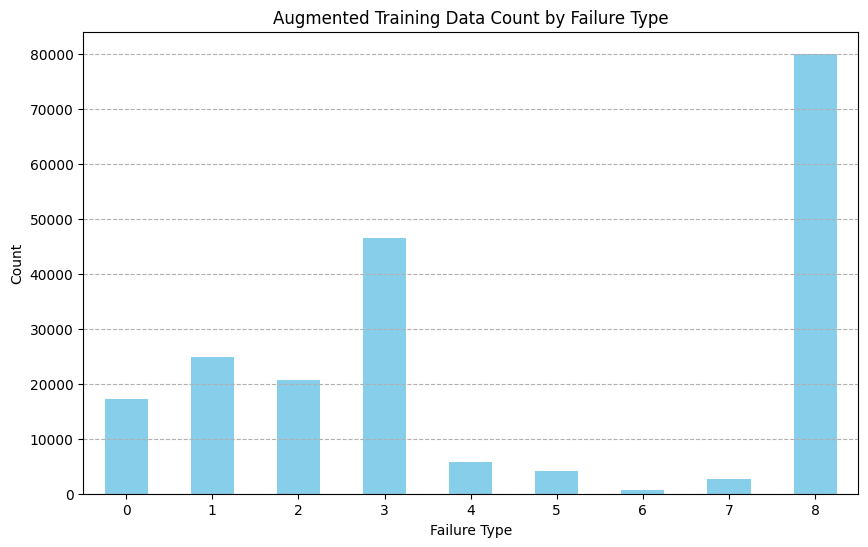

In [23]:
import matplotlib.pyplot as plt

# 결함 유형별 데이터 개수 그래프 그리기
plt.figure(figsize=(10, 6))
failure_counts_augmented.sort_index().plot(kind='bar', color='skyblue')
plt.title('Augmented Training Data Count by Failure Type')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

In [24]:
import numpy as np
import pandas as pd

# 특징 추출 함수
def extract_features(wafer_maps):
    features = []
    
    for wafer_map in wafer_maps:
        # 1. 결함 다이 비율
        total_pixels = wafer_map.size  # 전체 다이 개수
        defect_count = np.sum(wafer_map == 2)  # 2의 개수
        defect_ratio = defect_count / total_pixels if total_pixels > 0 else 0

        # 2. 결함 분포 (중앙값과 가장자리 근처에 집중되는지)
        defect_indices = np.argwhere(wafer_map == 2)  # 결함 위치의 인덱스
        if defect_indices.size > 0:
            center_of_defects = np.mean(defect_indices, axis=0)  # 결함 위치의 중앙
            distance_to_center = np.linalg.norm(defect_indices - center_of_defects, axis=1)  # 중앙에서의 거리
            avg_distance = np.mean(distance_to_center)  # 평균 거리
        else:
            center_of_defects = np.array([np.nan, np.nan])
            avg_distance = np.nan

        # 3. 픽셀 기반 통계 값 (평균 및 분산)
        mean_value = np.mean(wafer_map)
        variance_value = np.var(wafer_map)

        # 특징 추가
        features.append({
            'defect_ratio': defect_ratio,
            'center_of_defects': center_of_defects,
            'avg_distance_to_center': avg_distance,
            'mean_value': mean_value,
            'variance_value': variance_value
        })

    return pd.DataFrame(features)

# 특징 추출
features_df = extract_features(X_train_aug)

# 결과 확인
print(features_df.head())

   defect_ratio center_of_defects  avg_distance_to_center  mean_value  \
0           0.0        [nan, nan]                     NaN    0.462516   
1           0.0        [nan, nan]                     NaN    0.490242   
2           0.0        [nan, nan]                     NaN    0.211850   
3           0.0        [nan, nan]                     NaN    0.346381   
4           0.0        [nan, nan]                     NaN    0.105854   

   variance_value  
0        0.106918  
1        0.099720  
2        0.104561  
3        0.120113  
4        0.064023  


In [25]:
import numpy as np

class FeatureExtraction:
    def __init__(self):
        pass
    
    def __call__(self, arr):
        return self.forward(arr)
    
    def forward(self, arr):
        n_rows, n_cols = arr.shape
        n_splits = 8  # 구간 개수
        stride = 4  # 겹치는 간격 설정

        # 각 구간에 대해 추출할 통계 수치의 개수 (기존 4개에서 IQR, min, max 추가로 7개로 변경)
        num_features = 7
        # 결과를 저장할 배열 초기화 (n_rows, 8 * num_features)
        result = np.zeros((n_rows, n_splits * num_features))
        
        # 각 행에 대해 반복
        for i in range(n_rows):
            row = arr[i]
            features = []
            
            # 각 구간에 대해 통계 값 계산
            for j in range(n_splits):
                start = j * stride
                end = start + (n_cols // n_splits)
                
                # 구간이 배열의 경계를 넘지 않도록 보정
                if end > n_cols:
                    end = n_cols
                
                segment = row[start:end]
                
                # 기본 통계 값 계산
                mean = np.mean(segment)
                std = np.std(segment)
                var = np.var(segment)
                summation = np.sum(segment)
                
                # 추가 통계 값 계산
                iqr = np.percentile(segment, 75) - np.percentile(segment, 25)
                minimum = np.min(segment)
                maximum = np.max(segment)
                
                # 모든 통계 값 추가
                features.extend([mean, std, var, summation, iqr, minimum, maximum])
            
            # 결과 배열에 통계 값 저장
            result[i] = features
        
        return result



In [ ]:
X_train_aug[0].shape

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader

class WaferDataset(Dataset):
    def __init__(self, wafer_maps, labels):
        # 데이터셋 초기화 (wafer_maps: 웨이퍼 맵 열, labels: 원핫 인코딩된 레이블 열)
        self.wafer_maps = wafer_maps.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True) # 레이블을 float32로 변환

    def __len__(self):
        # 데이터셋 크기 반환
        return len(self.wafer_maps)

    def __getitem__(self, idx):
        # 웨이퍼 맵을 float32로 변환하여 텐서로 변환
        wafer_map = self.wafer_maps[idx]
        wafer_map_tensor = torch.tensor(wafer_map, dtype=torch.float32).unsqueeze(0).to(torch.float32)
        
        # 레이블을 텐서로 변환
        label = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)
        return wafer_map_tensor.to('cuda'), label.to('cuda')

